In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import os
import warnings

from __future__ import annotations
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting import set_bokeh_output
from glob import glob
from pathlib import Path
from scipy.stats import skew, kurtosis
from tabulate import tabulate 
from tqdm import tqdm
from tqdm import TqdmWarning
from typing import List

warnings.filterwarnings("ignore", category=TqdmWarning)
set_bokeh_output(notebook=False)
warnings.filterwarnings(
    "ignore",
    message="Jupyter Notebook detected. Setting Bokeh output to notebook."
)

# Définir le répertoire contenant vos fichiers parquet
data_dir = "../../data/crypto_data"

# Lister tous les fichiers .parquet
all_files = glob(os.path.join(data_dir, "*.parquet"))
for i in all_files:
    print(i)

/Users/sloutmyv/Documents/Github/trading-overview/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sloutmyv/Documents/Github/trading-overview/.venv/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

../../data/crypto_data/btcusdc_15m.parquet
../../data/crypto_data/btcusdc_1h.parquet
../../data/crypto_data/btcusdc_1m.parquet
../../data/crypto_data/btcusdc_1d.parquet
../../data/crypto_data/btcusdc_4h.parquet


In [2]:
# Charger le fichier BTCUSDC en timeframe 1d
btc_file = data_dir + "/btcusdc_1d.parquet"
df = pd.read_parquet(btc_file)

# Vérifier le chargement
print(df.shape)
df.tail()

(2197, 12)


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,nb_trades,taker_buy_base,taker_buy_quote,ignore
2192,1748304000000,109478.01,110799.10,107547.13,108992.92,4879.95661,1748390399999,5.345024e+08,938591,2301.80236,2.522084e+08,0.0
2193,1748390400000,108992.92,109334.92,106814.85,107817.98,3549.21863,1748476799999,3.838646e+08,825601,1602.79008,1.733672e+08,0.0
2194,1748476800000,107817.98,108941.17,105333.00,105586.03,4356.44792,1748563199999,4.672355e+08,1109751,2141.01011,2.296995e+08,0.0
2195,1748563200000,105586.03,106342.00,103657.40,104041.77,5076.54853,1748649599999,5.333837e+08,1301466,2477.16699,2.603056e+08,0.0
2196,1748649600000,104041.76,104343.15,103127.00,103671.99,789.23508,1748735999999,8.187079e+07,212000,353.08902,3.663033e+07,0.0


In [3]:
# -------------------------------------------------------------------
# Le jeu de donnée extrait de Binance comporte quelques erreurs dans les dates. Cette fonction permet de reconstruire l'index 
# temporel pour la suite. 
# Paramètres à ajuster par l'utilisateur :
#   - df : votre DataFrame d'origine contenant la colonne 'open_time'
#   - time_decrement : chaîne définissant l'unité de décrémentation ("4H", "1H", "1T", "1D", etc.)
# -------------------------------------------------------------------

def reconstruire_index_temporel(df: pd.DataFrame, time_decrement: str) -> pd.DataFrame:
    # 1. Filtrer les colonnes souhaitées
    df_filtered = df[['open', 'high', 'low', 'close', 'volume']].copy()
    df_filtered = df_filtered.rename(
    columns=dict(
        open="Open",
        high="High",
        low="Low",
        close="Close",
        volume="Volume",
    )
)

    # 2. Récupérer le dernier timestamp de 'open_time' (en millisecondes)
    last_ts = df['open_time'].iloc[-1]
    last_date = pd.to_datetime(last_ts, unit='ms')

    # 3. Construire l'objet Timedelta selon time_decrement
    #    Pandas accepte des strings comme "4H" (4 heures), "1H" (1 heure), "15T" (15 minutes), "1D" (1 jour), etc.
    delta = pd.Timedelta(time_decrement)

    # 4. Calculer la date de départ : 
    #    start_date = last_date - (n-1) * delta
    n = len(df_filtered)
    start_date = last_date - delta * (n - 1)

    # 5. Générer la plage de dates avec freq=delta
    date_index = pd.date_range(start=start_date, periods=n, freq=delta)

    # 6. Assigner l'index 'Date' au DataFrame filtré
    df_filtered.index = date_index
    df_filtered.index.name = 'Date'

    return df_filtered

time_decrement = "1D"
df_initial = reconstruire_index_temporel(df, time_decrement)
print(df_initial.head())


               Open     High      Low    Close       Volume
Date                                                       
2019-05-27  3200.00  3312.32  3000.00  3183.47   283.213859
2019-05-28  3183.47  3257.31  3178.54  3199.27   423.048529
2019-05-29  3192.69  3587.35  3187.25  3494.65  1163.940291
2019-05-30  3507.62  3683.35  3428.34  3670.11  1251.139627
2019-05-31  3673.18  3920.00  3618.53  3676.32  2655.242827


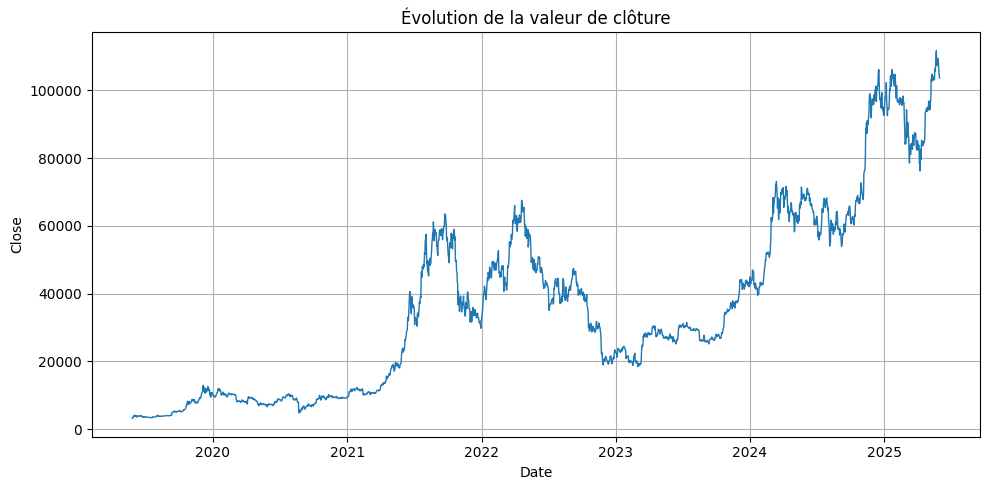

In [4]:
# Vérification que le jeu de donnée est cohérent
# Tracer la colonne 'close' en fonction de l'index temporel
plt.figure(figsize=(10, 5))
plt.plot(df_initial.index, df_initial['Close'], linewidth=1)
plt.title("Évolution de la valeur de clôture")
plt.xlabel("Date")
plt.ylabel("Close")
plt.grid(True)
plt.tight_layout()
plt.show()

Bougies df_initial : 2197
Bougies df_train : 1097
Bougies df_test : 731


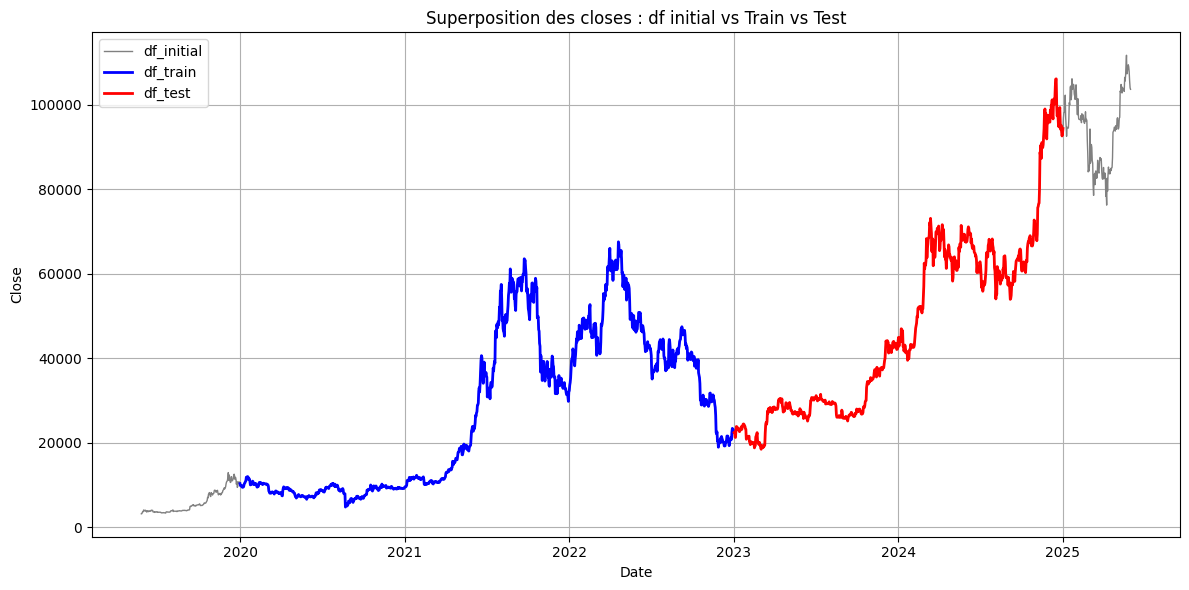

In [5]:
# Batir le jeu de donnée d'entrainement et le jeu de donnée de test
# 1. Définir les bornes de dates pour l'entraînement et le test
train_start, train_end = "2020-01-01", "2023-01-01"
test_start, test_end   = "2023-01-02", "2025-01-01"

# 2. S'assurer que l'index est de type datetime
df_initial.index = pd.to_datetime(df_initial.index)

# 3. Filtrer pour créer df_train et df_test
df_train = df_initial.loc[train_start:train_end].copy()
df_test  = df_initial.loc[test_start:test_end].copy()

print(f"Bougies df_initial : {df_initial.shape[0]}")
print(f"Bougies df_train : {df_train.shape[0]}")
print(f"Bougies df_test : {df_test.shape[0]}")

plt.figure(figsize=(12, 6))

# Tracer la série 'Close' du DataFrame complet
plt.plot(df_initial.index, df_initial['Close'], label='df_initial', color='gray', linewidth=1)

# Tracer la série 'Close' du DataFrame d’entraînement
plt.plot(df_train.index, df_train['Close'], label='df_train', color='blue', linewidth=2)

# Tracer la série 'Close' du DataFrame de test
plt.plot(df_test.index, df_test['Close'], label='df_test', color='red', linewidth=2)

plt.title("Superposition des closes : df initial vs Train vs Test")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# ─── Stratégie paramétrable ───────────────────────────────────────────────────
class EMACrossoverStrategy(Strategy):
    # Paramètres configurables
    short_span = 12  # short EMA
    long_span = 26  # long  EMA
    position_size = 0.5  
    risk_percent = 0.01  
    tp_sl_ratio = 2 

    def init(self):
        self.ema_short = self.I(
            lambda c, s: pd.Series(c).ewm(span=s, adjust=False).mean(),
            self.data.Close,
            self.short_span,
            name="EMA_short",
        )
        self.ema_long = self.I(
            lambda c, l: pd.Series(c).ewm(span=l, adjust=False).mean(),
            self.data.Close,
            self.long_span,
            name="EMA_long",
        )

    def next(self):
        if self.position:
            return

        if crossover(self.ema_short, self.ema_long):
            price = self.data.Close[-1]
            pos_val = self.equity * self.position_size
            qty = pos_val / price

            risk_amt = self.equity * self.risk_percent
            sl_per_sat = risk_amt / qty
            stop_price = price - sl_per_sat
            take_price = price + sl_per_sat * self.tp_sl_ratio

            if stop_price > 0 and take_price > price:
                self.buy(size=self.position_size, sl=stop_price, tp=take_price)

In [7]:
df_train_bt = df_train.copy()
df_test_bt = df_test.copy()

# ─── Conversion BTC → satoshis pour éviter le fractional trading ─────────────
SATOSHIS_PER_BTC = 100_000_000
for col in ["Open", "High", "Low", "Close"]:
    df_train_bt[col] /= SATOSHIS_PER_BTC
    df_test_bt[col] /= SATOSHIS_PER_BTC

In [8]:
# Stratégie EMA12/26
# ─── Paramètres utilisateur ───────────────────────────────────────────────────
INITIAL_CAPITAL = 3_000         # Capital de départ (USDC)
COMMISSION = 0.01               # 0,05 % de frais (réduit) → 0.01 = 1 %

bt = Backtest(
    df_train_bt,
    EMACrossoverStrategy,
    cash=INITIAL_CAPITAL,
    commission=COMMISSION,
    trade_on_close=True,
    exclusive_orders=True,
)

stats = bt.run(
    short_span=12,
    long_span=26,
    position_size=0.5,
    risk_percent=0.01,
    tp_sl_ratio=2,
    )

# ─── Mise en forme & export des statistiques ────────────────────────────────
def _beautify(val):
    """Pourcentages jolis pour |val| < 1, sinon 2 décimales."""
    if isinstance(val, (float, int)):
        if abs(val) < 1 and val != 0:
            return f"{val:.2%}"
        return f"{val:.2f}"
    return val

stats_df = stats.to_frame(name="Value")
stats_df.index.name = "Metric"

stats_formatted = stats_df.head(31).map(_beautify)

mapper = "map" if hasattr(stats_df, "map") else "applymap"
stats_formatted = getattr(stats_df.head(31), mapper)(_beautify)

print("\n===== Statistiques EMA 12/26 =====")
print(tabulate(
    stats_formatted.reset_index(),   # tabulate n'aime pas les index hiérarchiques
    headers=["Metric", "Value"],
    tablefmt="github",
))

# ─── Plot du backtest ────────────────────────────────────────────────────────
bt.plot()
plt.show()



===== Statistiques EMA 12/26 =====
|    | Metric                 | Value               |
|----|------------------------|---------------------|
|  0 | Start                  | 2020-01-01 00:00:00 |
|  1 | End                    | 2023-01-01 00:00:00 |
|  2 | Duration               | 1096 days 00:00:00  |
|  3 | Exposure Time [%]      | 3.83                |
|  4 | Equity Final [$]       | 2453.30             |
|  5 | Equity Peak [$]        | 3000.00             |
|  6 | Commissions [$]        | 436.47              |
|  7 | Return [%]             | -18.22              |
|  8 | Buy & Hold Return [%]  | 119.78              |
|  9 | Return (Ann.) [%]      | -6.47               |
| 10 | Volatility (Ann.) [%]  | 4.07                |
| 11 | CAGR [%]               | -6.48               |
| 12 | Sharpe Ratio           | -1.59               |
| 13 | Sortino Ratio          | -1.58               |
| 14 | Calmar Ratio           | -35.53%             |
| 15 | Alpha [%]              | -18.52        

In [9]:
# Recherche des meilleurs paramètres pour la stratégie 

# ─── Définition de la grille de recherche ─────────────────────────────────────
SHORT_SPANS = range(6, 12, 3)  
LONG_SPANS = range(9, 26, 2) 
POSITION_SIZES = [0.25, 0.5]
RISK_PERCENTS = [0.005, 0.01]  # 0.5 % ou 1 %
TP_SL_RATIOS = [2.0, 3.0]

TOP_N_PRINT = 10 # Affichage de X meilleurs résultats

# Liste de l'ensemble des combinaisons possibles
param_grid = list(itertools.product(SHORT_SPANS, LONG_SPANS, POSITION_SIZES, RISK_PERCENTS, TP_SL_RATIOS))
param_grid = [p for p in param_grid if p[0] < p[1]] # Filtre rapide : EMA courte doit être < EMA longue

print(f"[i] {len(param_grid)} combinaisons à tester")

# ─── Loop de backtests & collecte des stats ───────────────────────────────────
results = []

bt_train = Backtest(
    df_train_bt,
    EMACrossoverStrategy,
    cash=INITIAL_CAPITAL,
    commission=COMMISSION,
    trade_on_close=True,
    exclusive_orders=True,
)

for s_span, l_span, p_size, r_pct, tp_ratio in tqdm(param_grid, ncols=80):
    stats = bt_train.run(
        short_span=s_span,
        long_span=l_span,
        position_size=p_size,
        risk_percent=r_pct,
        tp_sl_ratio=tp_ratio,
    )
    results.append(
        {
            "short_span": s_span,
            "long_span": l_span,
            "position_size": p_size,
            "risk_percent": r_pct,
            "tp_sl_ratio": tp_ratio,
            **stats.to_dict(),
        }
    )


# ─── DataFrame final + tri sur le rendement net ──────────────────────────────
res_df = pd.DataFrame(results).sort_values("Return [%]", ascending=False)

# ─── Affichage console du TOP N ──────────────────────────────────────────────

cols_show = [
    "short_span",
    "long_span",
    "position_size",
    "risk_percent",
    "tp_sl_ratio",
    "Return [%]",
    "Sharpe Ratio",
    "Max. Drawdown [%]",
]

print(f"\n=== TOP {TOP_N_PRINT} par Return [%] (train) ===")
print(
    tabulate(
        res_df.head(TOP_N_PRINT)[cols_show],
        headers="keys",
        tablefmt="github",
        floatfmt=".2f",
    )
)

[i] 136 combinaisons à tester


100%|█████████████████████████████████████████| 136/136 [00:02<00:00, 52.60it/s]


=== TOP 10 par Return [%] (train) ===
|     |   short_span |   long_span |   position_size |   risk_percent |   tp_sl_ratio |   Return [%] |   Sharpe Ratio |   Max. Drawdown [%] |
|-----|--------------|-------------|-----------------|----------------|---------------|--------------|----------------|---------------------|
|  75 |         9.00 |       11.00 |            0.25 |           0.01 |          3.00 |         6.38 |           0.36 |               -7.04 |
| 107 |         9.00 |       19.00 |            0.25 |           0.01 |          3.00 |         3.08 |           0.21 |               -6.19 |
| 106 |         9.00 |       19.00 |            0.25 |           0.01 |          2.00 |         2.68 |           0.24 |               -5.23 |
|  11 |         6.00 |       11.00 |            0.25 |           0.01 |          3.00 |         2.66 |           0.15 |               -8.05 |
|  19 |         6.00 |       13.00 |            0.25 |           0.01 |          3.00 |         1.71 |       

In [10]:
# ─── Exécution du meilleur run sur train ───────────────────────────
best_params = res_df.iloc[0][
    [
        "short_span",
        "long_span",
        "position_size",
        "risk_percent",
        "tp_sl_ratio",
    ]
].to_dict()

# Ré-exécution sur le train pour affichage/plot
best_stats_train = bt_train.run(**best_params)

# ─── Plot du best train backtest ────────────────────────────────────────────────────────
bt_train.plot()
plt.show()

In [11]:
# Générer des permutation sur df_train et df_test

DEFAULT_OUTPUT_TRAIN_DIR = Path("train_perm/") # Répertoire de sortie par défaut pour les permutations
DEFAULT_OUTPUT_TEST_DIR = Path("test_perm/") # Répertoire de sortie par défaut pour les permutations
DEFAULT_SEED = 42 # Graine aléatoire par défaut pour la reproductibilité
OHLC_COLS = ["Open", "High", "Low", "Close"] # Colonnes OHLC attendues et utilisées (sensible à la casse)

def _permute_segment(
    df: pd.DataFrame,
    seg_start: int,
    seg_end: int,
    *,
    n_perm: int,
    seed: int | None = None,
) -> List[pd.DataFrame]:
    """Retourne *n_perm* permutations de ``df`` restreintes à ``[seg_start, seg_end]``.

    Les barres en dehors de cet intervalle inclusif restent identiques à l'original.
    La permutation préserve la structure statistique des barres OHLC en
    mélangeant les plages (H/L/C) ensemble et les gaps (open–close) indépendamment.
    """

    if not (0 <= seg_start <= seg_end < len(df) or (len(df) == 0 and seg_start == 0 and seg_end == -1)):
        raise ValueError(f"Limites de segment invalides: seg_start={seg_start}, seg_end={seg_end}, len(df)={len(df)}")

    if len(df) == 0:
        return [pd.DataFrame(columns=OHLC_COLS, index=df.index) for _ in range(n_perm)]

    # Vérifier qu'il n'y a pas de valeurs nulles ou négatives dans les données OHLC
    ohlc_data = df[OHLC_COLS]
    if ohlc_data.isnull().any().any():
        print("Attention: Des valeurs NaN détectées dans les données OHLC d'entrée")
    if (ohlc_data <= 0).any().any():
        print("Attention: Des valeurs négatives ou nulles détectées dans les données OHLC")

    logp = np.log(df[OHLC_COLS])
    
    # Gérer le cas où seg_start = 0 pour éviter les NaN
    if seg_start == 0:
        # Pour la première barre, on ne peut pas calculer un gap depuis la barre précédente
        # On utilise un gap de 0 (pas de gap) pour la première position
        gap_open_series = logp["Open"] - logp["Close"].shift()
        gap_open_series.iloc[0] = 0.0  # Pas de gap pour la première barre
    else:
        gap_open_series = logp["Open"] - logp["Close"].shift()
    
    gap_open  = gap_open_series.iloc[seg_start : seg_end + 1].to_numpy()
    rel_high  = (logp["High"] - logp["Open"]).iloc[seg_start : seg_end + 1].to_numpy()
    rel_low   = (logp["Low"]  - logp["Open"]).iloc[seg_start : seg_end + 1].to_numpy()
    rel_close = (logp["Close"] - logp["Open"]).iloc[seg_start : seg_end + 1].to_numpy()

    # Vérifier s'il y a des NaN dans les arrays extraits
    arrays_to_check = [gap_open, rel_high, rel_low, rel_close]
    array_names = ['gap_open', 'rel_high', 'rel_low', 'rel_close']
    
    for arr, name in zip(arrays_to_check, array_names):
        if np.isnan(arr).any():
            print(f"Attention: Des valeurs NaN détectées dans {name}")
            print(f"Positions NaN dans {name}: {np.where(np.isnan(arr))[0]}")

    seg_len    = seg_end - seg_start + 1
    time_index = df.index

    def _one_perm(rng: np.random.Generator) -> pd.DataFrame:
        order_bar = rng.permutation(seg_len)
        order_gap = rng.permutation(seg_len)

        _rel_high  = rel_high[order_bar]
        _rel_low   = rel_low[order_bar]
        _rel_close = rel_close[order_bar]
        _gap_open  = gap_open[order_gap]

        bars = logp.to_numpy().copy()

        # Déterminer le point d'ancrage pour la première barre du segment
        if seg_start == 0:
            # Si on commence au début, utiliser la première valeur d'open comme base
            last_close = bars[0, OHLC_COLS.index("Open")] - _gap_open[0]
        else:
            # Sinon, utiliser la valeur de close de la barre précédente
            last_close = bars[seg_start - 1, OHLC_COLS.index("Close")]

        for k in range(seg_len):
            i_row = seg_start + k
            
            # Calculer les nouvelles valeurs
            new_open = last_close + _gap_open[k]
            new_high = new_open + _rel_high[k]
            new_low  = new_open + _rel_low[k]
            new_close = new_open + _rel_close[k]
            
            # Vérifier la cohérence OHLC (High >= max(Open, Close), Low <= min(Open, Close))
            actual_high = max(new_open, new_close, new_high)
            actual_low = min(new_open, new_close, new_low)
            
            bars[i_row, OHLC_COLS.index("Open")] = new_open
            bars[i_row, OHLC_COLS.index("High")] = actual_high
            bars[i_row, OHLC_COLS.index("Low")]  = actual_low
            bars[i_row, OHLC_COLS.index("Close")] = new_close
            
            last_close = new_close

        # Vérifier s'il y a des NaN dans le résultat final
        if np.isnan(bars).any():
            print("Attention: Des valeurs NaN générées dans une permutation")
            nan_positions = np.where(np.isnan(bars))
            print(f"Positions NaN: lignes {nan_positions[0]}, colonnes {nan_positions[1]}")

        return pd.DataFrame(
            np.exp(bars), index=time_index, columns=OHLC_COLS
        )

    master_rng = np.random.default_rng(seed)
    return [
        _one_perm(np.random.default_rng(master_rng.integers(0, 2**32 - 1)))
        for _ in range(n_perm)
    ]


def _write_permutations(
    perms: List[pd.DataFrame],
    output_dir: Path,
    original_df: pd.DataFrame, # L'original complet pour référence, mais seul OHLC sera écrit de perms
) -> List[Path]:
    output_dir.mkdir(parents=True, exist_ok=True)
    written_files: List[Path] = []

    # Sauvegarder l'original complet comme perm000
    orig_path = output_dir / "perm000.parquet"
    original_df.to_parquet(orig_path)
    written_files.append(orig_path)

    for i, p_df in enumerate(perms, start=1):
        p_path = output_dir / f"perm{i:03d}.parquet"
        
        # Vérifier s'il y a des NaN avant de sauvegarder
        if p_df.isnull().any().any():
            print(f"Attention: Des valeurs NaN détectées dans perm{i:03d}")
            print(f"Nombre de NaN par colonne:")
            for col in p_df.columns:
                nan_count = p_df[col].isnull().sum()
                if nan_count > 0:
                    print(f"  {col}: {nan_count} NaN")
        
        p_df.to_parquet(p_path)
        written_files.append(p_path)
        
    return written_files


def generate_ohlc_permutations(
    input_df: pd.DataFrame,
    num_permutations: int,
    *,
    output_dir: Path = DEFAULT_OUTPUT_TRAIN_DIR,  # Correction: utilisait DEFAULT_OUTPUT_DIR non défini
    seed: int | None = DEFAULT_SEED,
) -> None:
    if not isinstance(input_df, pd.DataFrame):
        raise TypeError("L'entrée 'input_df' doit être un DataFrame pandas.")
    if not all(col in input_df.columns for col in OHLC_COLS):
        raise ValueError(f"Le DataFrame d'entrée doit contenir les colonnes {', '.join(OHLC_COLS)}.")
    if num_permutations < 0:
        raise ValueError("Le nombre de permutations 'num_permutations' ne peut pas être négatif.")

    print(f"DataFrame d'entrée chargé avec {len(input_df)} barres.")
    print(f"Colonnes OHLC utilisées pour la permutation : {OHLC_COLS}")
    
    # Vérification des données d'entrée
    ohlc_data = input_df[OHLC_COLS]
    if ohlc_data.isnull().any().any():
        print("ATTENTION: Le DataFrame d'entrée contient des valeurs NaN!")
        for col in OHLC_COLS:
            nan_count = ohlc_data[col].isnull().sum()
            if nan_count > 0:
                print(f"  {col}: {nan_count} valeurs NaN")
        
    if (ohlc_data <= 0).any().any():
        print("ATTENTION: Le DataFrame d'entrée contient des valeurs négatives ou nulles!")
        
    extra_cols = [col for col in input_df.columns if col not in OHLC_COLS]
    if extra_cols:
        print(f"Note : Les colonnes suivantes ne seront pas incluses dans les permutations (perm001 et au-delà) : {extra_cols}")
        print("Le fichier perm000.parquet sera une copie exacte du DataFrame d'entrée complet.")

    if len(input_df) == 0:
        print("Le DataFrame d'entrée est vide. Seul perm000.parquet (copie de l'entrée vide) sera créé.")
        permuted_dataframes = []
    elif num_permutations == 0:
        print("num_permutations est 0. Seul perm000.parquet (copie de l'original) sera créé.")
        permuted_dataframes = []
    else:
        print(f"Génération de {num_permutations} permutation(s) pour les colonnes OHLC du DataFrame...")
        seg_start = 0
        seg_end = len(input_df) - 1
        
        permuted_dataframes = _permute_segment(
            input_df.copy(),
            seg_start, 
            seg_end, 
            n_perm=num_permutations, 
            seed=seed
        )
    
    written_files = _write_permutations(
        permuted_dataframes, output_dir, original_df=input_df
    )

    cwd = Path.cwd()
    print("\nFichiers générés :")
    for p in written_files:
        try:
            print(f"  → {p.relative_to(cwd)}")
        except ValueError:
            print(f"  → {p}")
    print(f"\nOpération terminée. {len(written_files)} fichier(s) au total dans {output_dir}.")


# Exemple d'utilisation (à adapter selon vos DataFrames df_train et df_test)
if __name__ == "__main__":
    N_PERM_EXAMPLE = 50 # Petit nombre pour l'exemple

    # Assurez-vous que df_train et df_test sont définis avant d'exécuter
    generate_ohlc_permutations(
        input_df=df_train,
        num_permutations=N_PERM_EXAMPLE,
        output_dir=DEFAULT_OUTPUT_TRAIN_DIR,
        seed=DEFAULT_SEED
    )

    generate_ohlc_permutations(
        input_df=df_test,
        num_permutations=N_PERM_EXAMPLE,
        output_dir=DEFAULT_OUTPUT_TEST_DIR,
        seed=DEFAULT_SEED
    )

DataFrame d'entrée chargé avec 1097 barres.
Colonnes OHLC utilisées pour la permutation : ['Open', 'High', 'Low', 'Close']
Note : Les colonnes suivantes ne seront pas incluses dans les permutations (perm001 et au-delà) : ['Volume']
Le fichier perm000.parquet sera une copie exacte du DataFrame d'entrée complet.
Génération de 50 permutation(s) pour les colonnes OHLC du DataFrame...

Fichiers générés :
  → train_perm/perm000.parquet
  → train_perm/perm001.parquet
  → train_perm/perm002.parquet
  → train_perm/perm003.parquet
  → train_perm/perm004.parquet
  → train_perm/perm005.parquet
  → train_perm/perm006.parquet
  → train_perm/perm007.parquet
  → train_perm/perm008.parquet
  → train_perm/perm009.parquet
  → train_perm/perm010.parquet
  → train_perm/perm011.parquet
  → train_perm/perm012.parquet
  → train_perm/perm013.parquet
  → train_perm/perm014.parquet
  → train_perm/perm015.parquet
  → train_perm/perm016.parquet
  → train_perm/perm017.parquet
  → train_perm/perm018.parquet
  → trai

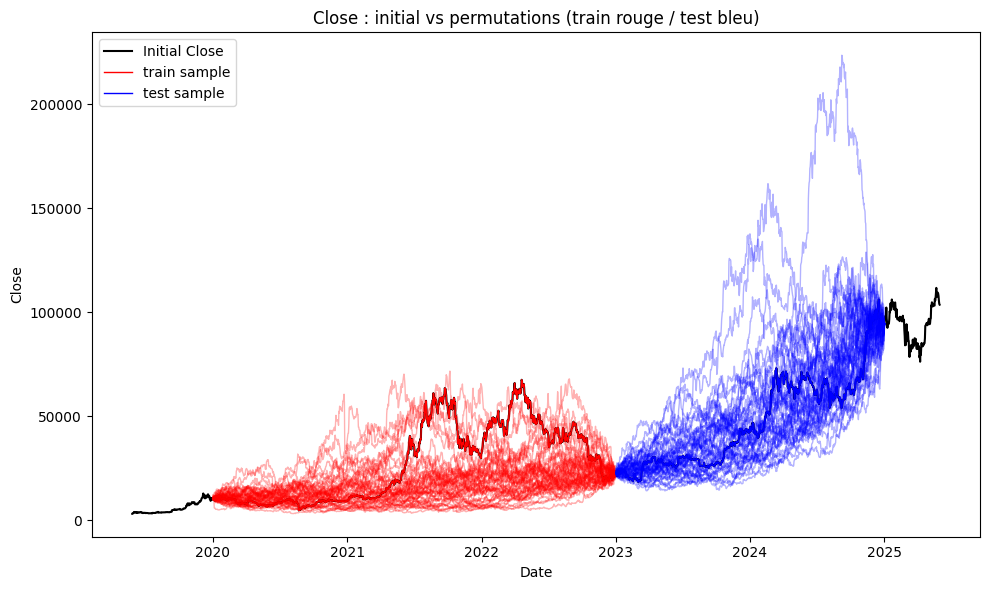


Statistical comparison — train_perm (log-returns)
perm000 :  mean=7.185e-04  std=4.021e-02  skew=-1.765  kurt=24.410
ensemble: mean=6.882e-04  std=4.020e-02  skew=-1.780  kurt=24.570

Statistical comparison — test_perm (log-returns)
perm000 :  mean=1.967e-03  std=2.634e-02  skew=0.415  kurt=3.344
ensemble: mean=1.941e-03  std=2.607e-02  skew=0.292  kurt=2.726


In [12]:
# === CONFIGURATION =========================================================
TRAIN_DIR   = Path("train_perm")   # jeu de référence
TEST_DIR  = Path("test_perm")  # NOUVEAU jeu à comparer
PATTERN  = "perm*.parquet"
COL      = "Close"
REBASE   = False
# ===========================================================================


###############################################################################
# DATA LOADING ################################################################
###############################################################################

def load_permutations(folder: Path, pattern: str = PATTERN):
    """Retourne une liste `(stem, ndarray_close)` triée par nom de fichier."""
    files = sorted(folder.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files matching {pattern} in {folder}")

    data: list[tuple[str, np.ndarray]] = []
    for fp in files:
        df = pd.read_parquet(fp)
        if COL not in df.columns:
            raise KeyError(f"Column '{COL}' missing in {fp.name}")
        arr = df[COL].to_numpy(copy=True)
        if REBASE:
            arr = arr / arr[0]
        data.append((fp.stem, arr))
    return data


###############################################################################
# STATISTICS ##################################################################
###############################################################################

def _log_returns(price: np.ndarray) -> np.ndarray:
    return np.diff(np.log(price))


def stat_summary(arr: np.ndarray) -> dict[str, float]:
    r = _log_returns(arr)
    return {
        "mean": float(r.mean()),
        "std":  float(r.std(ddof=0)),
        "skew": float(skew(r, bias=False)),
        "kurt": float(kurtosis(r, bias=False)),
    }


def print_comparison(data, title: str = "ensemble"):
    """Affiche les stats de perm000 et la moyenne de l’ensemble."""
    stats_perm0 = None
    ensemble = []

    for name, arr in data:
        st = stat_summary(arr)
        if name.endswith("perm000"):
            stats_perm0 = st
        ensemble.append(st)

    if stats_perm0 is None:
        raise ValueError("perm000 file not found in data set.")

    ensemble_df = pd.DataFrame(ensemble)
    stats_ens = ensemble_df.mean().to_dict()

    print(f"\nStatistical comparison — {title} (log-returns)")
    print("==============================================")
    print(f"perm000 :  mean={stats_perm0['mean']:.3e}  std={stats_perm0['std']:.3e}  "
          f"skew={stats_perm0['skew']:.3f}  kurt={stats_perm0['kurt']:.3f}")
    print(f"ensemble: mean={stats_ens['mean']:.3e}  std={stats_ens['std']:.3e}  "
          f"skew={stats_ens['skew']:.3f}  kurt={stats_ens['kurt']:.3f}")


###############################################################################
# PLOTTING ####################################################################
###############################################################################

def plot_permutations(train_dir: str, test_dir: str, df_initial: pd.DataFrame):
    """
    Trace la colonne 'Close' de df_initial (en noir) et, 
    depuis deux répertoires de fichiers Parquet (train_dir, test_dir) :
      • perm000.parquet en rouge opaque (train) et bleu opaque (test),
      • les autres permXXX.parquet en rouge transparent (train) et bleu transparent (test).
    L’axe des abscisses est l’index 'Date' (DatetimeIndex).
    
    Paramètres :
      train_dir  (str)           : chemin vers le dossier contenant train_perm/*.parquet
      test_dir   (str)           : chemin vers le dossier contenant test_perm/*.parquet
      df_initial (pd.DataFrame)  : DataFrame initial indexé par 'Date', doit contenir 'Close'
    """
    # Lister et trier les fichiers .parquet dans chaque répertoire
    train_files = sorted([f for f in os.listdir(train_dir) if f.endswith('.parquet')])
    test_files  = sorted([f for f in os.listdir(test_dir)  if f.endswith('.parquet')])

    plt.figure(figsize=(10, 6))
    # Tracer df_initial['Close'] en noir
    plt.plot(
        df_initial.index,
        df_initial['Close'],
        color='k',
        label='Initial Close'
    )

    # Parcourir les permutations d'entraînement
    for fname in train_files:
        path = os.path.join(train_dir, fname)
        df_perm = pd.read_parquet(path)

        if fname.startswith('perm000'):
            plt.plot(
                df_perm.index,
                df_perm['Close'],
                color='red',
                alpha=1.0,
                linewidth=1,
                label='train sample'
            )
        else:
            plt.plot(
                df_perm.index,
                df_perm['Close'],
                color='red',
                alpha=0.3,
                linewidth=1
                # pas d'étiquette pour éviter d'encombrer la légende
            )

    # Parcourir les permutations de test
    for fname in test_files:
        path = os.path.join(test_dir, fname)
        df_perm = pd.read_parquet(path)

        if fname.startswith('perm000'):
            plt.plot(
                df_perm.index,
                df_perm['Close'],
                color='blue',
                alpha=1.0,
                linewidth=1,
                label='test sample'
            )
        else:
            plt.plot(
                df_perm.index,
                df_perm['Close'],
                color='blue',
                alpha=0.3,
                linewidth=1
            )

    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend(loc='best')
    plt.title('Close : initial vs permutations (train rouge / test bleu)')
    plt.tight_layout()
    plt.show()


###############################################################################
# MAIN ########################################################################
###############################################################################

if __name__ == "__main__":
    # Chargement des deux jeux
    train_data  = load_permutations(TRAIN_DIR)
    test_data = load_permutations(TEST_DIR)

    # 1) Affichage graphique combiné
    plot_permutations(TRAIN_DIR, TEST_DIR, df_initial)

    # 2) Résumés statistiques indépendants
    print_comparison(train_data,  title="train_perm")
    print_comparison(test_data, title="test_perm")


In [17]:
# Test des meilleurs paramètres sur les train_perm

# ─── Paramètres généraux ──────────────────────────────────────────────────────
PERM_DIR = Path("train_perm")
REFERENCE_FILE = PERM_DIR / "perm000.parquet"

def prepare_data(df):
    """Prépare les données pour le backtesting"""       
    # Conversion BTC → satoshis
    SATOSHIS_PER_BTC = 100_000_000
    df[["Open", "High", "Low", "Close"]] /= SATOSHIS_PER_BTC
    
    return df

def run_backtest(df_data, params):
    """Exécute un backtest avec les paramètres donnés"""
    bt = Backtest(
        df_data,
        EMACrossoverStrategy,
        cash=INITIAL_CAPITAL,
        commission=COMMISSION,
        trade_on_close=True,
        exclusive_orders=True,
    )
    
    stats = bt.run(**params)
    return stats["Return [%]"]

# ─── Calcul du rendement de référence ─────
print("[1/3] Calcul du rendement de référence sur perm000")

if not REFERENCE_FILE.exists():
    raise FileNotFoundError(f"Fichier de référence non trouvé : {REFERENCE_FILE}")

df_ref = pd.read_parquet(REFERENCE_FILE)
df_ref_bt = prepare_data(df_ref)
reference_return = run_backtest(df_ref_bt, best_params)
print(f"Rendement de référence (perm000, train set) : {reference_return:.2f}%")

# ─── Test sur toutes les permutations ────────────────────────────────────────
print("\n[2/3] Test sur les permutations")

# Recherche de tous les fichiers de permutation (sauf 000)
perm_files = sorted([
    f for f in PERM_DIR.glob("perm*.parquet")
    if not f.name.endswith("perm000.parquet")
])

if not perm_files:
    raise FileNotFoundError(f"Aucun fichier de permutation trouvé dans {PERM_DIR}")

print(f"Trouvé {len(perm_files)} fichiers de permutation à tester")

results = []
successful_tests = 0

for perm_file in tqdm(perm_files, desc="Test permutations"):
    try:
        # Charger et préparer les données de la permutation
        df_perm = pd.read_parquet(perm_file)
        df_perm_bt = prepare_data(df_perm)
        
        # Test sur l'ensemble de la permutation
        perm_return = run_backtest(df_perm_bt, best_params)
        
        results.append({
            "permutation": perm_file.stem,
            "return_pct": perm_return,
            "beats_reference": perm_return > reference_return
        })
        
        successful_tests += 1
        
    except Exception as e:
        print(f"Erreur avec {perm_file.name}: {e}")
        continue

# ─── Analyse des résultats ───────────────────────────────────────────────────
print(f"\n[3/3] Analyse des résultats ({successful_tests} tests réussis)...")

if not results:
    print("Aucun résultat à analyser !")
    exit(1)

results_df = pd.DataFrame(results)

# Statistiques générales
total_perms = len(results_df)
better_than_ref = results_df["beats_reference"].sum()
percentage_better = (better_than_ref / total_perms) * 100

avg_return = results_df["return_pct"].mean()
median_return = results_df["return_pct"].median()
std_return = results_df["return_pct"].std()

# ─── Affichage des résultats ─────────────────────────────────────────────────
print("=" * 70)
print("RÉSULTATS DU TEST SUR PERMUTATIONS (OUT-OF-SAMPLE)")
print("=" * 70)

print(f"Rendement de référence (perm000, test set): {reference_return:.2f}%")
print(f"Nombre total de permutations testées: {total_perms}")
print(f"Permutations avec rendement supérieur: {better_than_ref}")
print(f"Pourcentage de permutations battant la référence: {percentage_better:.1f}%")

print(f"\nStatistiques des rendements sur permutations (out-of-sample):")
print(f"  Moyenne: {avg_return:.2f}%")
print(f"  Médiane: {median_return:.2f}%")
print(f"  Écart-type: {std_return:.2f}%")
print(f"  Min: {results_df['return_pct'].min():.2f}%")
print(f"  Max: {results_df['return_pct'].max():.2f}%")

# Top 10 et Bottom 10
print(f"\n--- TOP 10 des meilleures permutations (out-of-sample) ---")
top_10 = results_df.nlargest(10, "return_pct")[["permutation", "return_pct"]]
print(tabulate(top_10, headers=["Permutation", "Rendement (%)"], tablefmt="github", floatfmt=".2f"))

print(f"\n--- TOP 10 des moins bonnes permutations (out-of-sample) ---")
bottom_10 = results_df.nsmallest(10, "return_pct")[["permutation", "return_pct"]]
print(tabulate(bottom_10, headers=["Permutation", "Rendement (%)"], tablefmt="github", floatfmt=".2f"))

# ─── Résumé final ────────────────────────────────────────────────────────────
print("\n" + "=" * 70)
print("CONCLUSION (OUT-OF-SAMPLE)")
print("=" * 70)

if percentage_better > 50:
    conclusion = "La stratégie se généralise bien (plus de 50% des permutations battent la référence)"
elif percentage_better > 25:
    conclusion = "La stratégie présente une généralisation modérée"
else:
    conclusion = "La stratégie pourrait souffrir d'overfitting (généralisation limitée)"

print(f"{conclusion}")
print(f"Score de généralisation: {percentage_better:.1f}% des permutations battent la référence")
print("\nCe test out-of-sample est crucial pour évaluer la robustesse de votre stratégie !")



[1/3] Calcul du rendement de référence sur perm000


Rendement de référence (perm000, train set) : 6.38%

[2/3] Test sur les permutations
Trouvé 50 fichiers de permutation à tester


Test permutations: 100%|██████████| 50/50 [00:01<00:00, 47.22it/s]


[3/3] Analyse des résultats (50 tests réussis)...
RÉSULTATS DU TEST SUR PERMUTATIONS (OUT-OF-SAMPLE)
Rendement de référence (perm000, test set): 6.38%
Nombre total de permutations testées: 50
Permutations avec rendement supérieur: 1
Pourcentage de permutations battant la référence: 2.0%

Statistiques des rendements sur permutations (out-of-sample):
  Moyenne: -11.80%
  Médiane: -13.58%
  Écart-type: 7.81%
  Min: -26.15%
  Max: 6.38%

--- TOP 10 des meilleures permutations (out-of-sample) ---
|    | Permutation   |   Rendement (%) |
|----|---------------|-----------------|
|  7 | perm008       |            6.38 |
| 34 | perm035       |            5.98 |
| 26 | perm027       |            2.99 |
| 12 | perm013       |            0.20 |
| 39 | perm040       |           -0.18 |
| 28 | perm029       |           -1.29 |
| 25 | perm026       |           -1.79 |
| 44 | perm045       |           -1.85 |
|  5 | perm006       |           -3.67 |
| 38 | perm039       |           -4.21 |

--- TOP 1

In [16]:
# Test de la stratégie sur l'échantillon de test
bt_test = Backtest(
    df_test_bt,
    EMACrossoverStrategy,
    cash=INITIAL_CAPITAL,
    commission=COMMISSION,
    trade_on_close=True,
    exclusive_orders=True,
)

# Ré-exécution sur le train pour affichage/plot
best_stats_test = bt_test.run(**best_params)

# ─── Mise en forme & export des statistiques ────────────────────────────────
def _beautify(val):
    """Pourcentages jolis pour |val| < 1, sinon 2 décimales."""
    if isinstance(val, (float, int)):
        if abs(val) < 1 and val != 0:
            return f"{val:.2%}"
        return f"{val:.2f}"
    return val

stats_df = best_stats_test.to_frame(name="Value")
stats_df.index.name = "Metric"

stats_formatted = stats_df.head(31).map(_beautify)

mapper = "map" if hasattr(stats_df, "map") else "applymap"
stats_formatted = getattr(stats_df.head(31), mapper)(_beautify)

print("\n===== Statistiques EMA 12/26 =====")
print(tabulate(
    stats_formatted.reset_index(),   # tabulate n'aime pas les index hiérarchiques
    headers=["Metric", "Value"],
    tablefmt="github",
))

# ─── Plot du best train backtest ────────────────────────────────────────────────────────
bt_test.plot()
plt.show()


===== Statistiques EMA 12/26 =====
|    | Metric                 | Value               |
|----|------------------------|---------------------|
|  0 | Start                  | 2023-01-02 00:00:00 |
|  1 | End                    | 2025-01-01 00:00:00 |
|  2 | Duration               | 730 days 00:00:00   |
|  3 | Exposure Time [%]      | 29.27               |
|  4 | Equity Final [$]       | 2857.60             |
|  5 | Equity Peak [$]        | 3058.80             |
|  6 | Commissions [$]        | 279.26              |
|  7 | Return [%]             | -4.75               |
|  8 | Buy & Hold Return [%]  | 320.41              |
|  9 | Return (Ann.) [%]      | -2.40               |
| 10 | Volatility (Ann.) [%]  | 5.57                |
| 11 | CAGR [%]               | -2.40               |
| 12 | Sharpe Ratio           | -43.06%             |
| 13 | Sortino Ratio          | -60.31%             |
| 14 | Calmar Ratio           | -27.19%             |
| 15 | Alpha [%]              | -20.56        

In [15]:
# Test des meilleurs paramètres sur les test_perm

# ─── Paramètres généraux ──────────────────────────────────────────────────────
PERM_DIR = Path("test_perm")
REFERENCE_FILE = PERM_DIR / "perm000.parquet"

def prepare_data(df):
    """Prépare les données pour le backtesting"""       
    # Conversion BTC → satoshis
    SATOSHIS_PER_BTC = 100_000_000
    df[["Open", "High", "Low", "Close"]] /= SATOSHIS_PER_BTC
    
    return df

def run_backtest(df_data, params):
    """Exécute un backtest avec les paramètres donnés"""
    bt = Backtest(
        df_data,
        EMACrossoverStrategy,
        cash=INITIAL_CAPITAL,
        commission=COMMISSION,
        trade_on_close=True,
        exclusive_orders=True,
    )
    
    stats = bt.run(**params)
    return stats["Return [%]"]

# ─── Calcul du rendement de référence ─────
print("[1/3] Calcul du rendement de référence sur perm000")

if not REFERENCE_FILE.exists():
    raise FileNotFoundError(f"Fichier de référence non trouvé : {REFERENCE_FILE}")

df_ref = pd.read_parquet(REFERENCE_FILE)
df_ref_bt = prepare_data(df_ref)
reference_return = run_backtest(df_ref_bt, best_params)
print(f"Rendement de référence (perm000, train set) : {reference_return:.2f}%")

# ─── Test sur toutes les permutations ────────────────────────────────────────
print("\n[2/3] Test sur les permutations")

# Recherche de tous les fichiers de permutation (sauf 000)
perm_files = sorted([
    f for f in PERM_DIR.glob("perm*.parquet")
    if not f.name.endswith("perm000.parquet")
])

if not perm_files:
    raise FileNotFoundError(f"Aucun fichier de permutation trouvé dans {PERM_DIR}")

print(f"Trouvé {len(perm_files)} fichiers de permutation à tester")

results = []
successful_tests = 0

for perm_file in tqdm(perm_files, desc="Test permutations"):
    try:
        # Charger et préparer les données de la permutation
        df_perm = pd.read_parquet(perm_file)
        df_perm_bt = prepare_data(df_perm)
        
        # Test sur l'ensemble de la permutation
        perm_return = run_backtest(df_perm_bt, best_params)
        
        results.append({
            "permutation": perm_file.stem,
            "return_pct": perm_return,
            "beats_reference": perm_return > reference_return
        })
        
        successful_tests += 1
        
    except Exception as e:
        print(f"Erreur avec {perm_file.name}: {e}")
        continue

# ─── Analyse des résultats ───────────────────────────────────────────────────
print(f"\n[3/3] Analyse des résultats ({successful_tests} tests réussis)...")

if not results:
    print("Aucun résultat à analyser !")
    exit(1)

results_df = pd.DataFrame(results)

# Statistiques générales
total_perms = len(results_df)
better_than_ref = results_df["beats_reference"].sum()
percentage_better = (better_than_ref / total_perms) * 100

avg_return = results_df["return_pct"].mean()
median_return = results_df["return_pct"].median()
std_return = results_df["return_pct"].std()

# ─── Affichage des résultats ─────────────────────────────────────────────────
print("=" * 70)
print("RÉSULTATS DU TEST SUR PERMUTATIONS (OUT-OF-SAMPLE)")
print("=" * 70)

print(f"Rendement de référence (perm000, test set): {reference_return:.2f}%")
print(f"Nombre total de permutations testées: {total_perms}")
print(f"Permutations avec rendement supérieur: {better_than_ref}")
print(f"Pourcentage de permutations battant la référence: {percentage_better:.1f}%")

print(f"\nStatistiques des rendements sur permutations (out-of-sample):")
print(f"  Moyenne: {avg_return:.2f}%")
print(f"  Médiane: {median_return:.2f}%")
print(f"  Écart-type: {std_return:.2f}%")
print(f"  Min: {results_df['return_pct'].min():.2f}%")
print(f"  Max: {results_df['return_pct'].max():.2f}%")

# Top 10 et Bottom 10
print(f"\n--- TOP 10 des meilleures permutations (out-of-sample) ---")
top_10 = results_df.nlargest(10, "return_pct")[["permutation", "return_pct"]]
print(tabulate(top_10, headers=["Permutation", "Rendement (%)"], tablefmt="github", floatfmt=".2f"))

print(f"\n--- TOP 10 des moins bonnes permutations (out-of-sample) ---")
bottom_10 = results_df.nsmallest(10, "return_pct")[["permutation", "return_pct"]]
print(tabulate(bottom_10, headers=["Permutation", "Rendement (%)"], tablefmt="github", floatfmt=".2f"))

# ─── Résumé final ────────────────────────────────────────────────────────────
print("\n" + "=" * 70)
print("CONCLUSION (OUT-OF-SAMPLE)")
print("=" * 70)

if percentage_better > 50:
    conclusion = "La stratégie se généralise bien (plus de 50% des permutations battent la référence)"
elif percentage_better > 25:
    conclusion = "La stratégie présente une généralisation modérée"
else:
    conclusion = "La stratégie pourrait souffrir d'overfitting (généralisation limitée)"

print(f"{conclusion}")
print(f"Score de généralisation: {percentage_better:.1f}% des permutations battent la référence")
print("\nCe test out-of-sample est crucial pour évaluer la robustesse de votre stratégie !")



[1/3] Calcul du rendement de référence sur perm000


Rendement de référence (perm000, train set) : -4.75%

[2/3] Test sur les permutations
Trouvé 50 fichiers de permutation à tester


Test permutations: 100%|██████████| 50/50 [00:00<00:00, 50.67it/s]


[3/3] Analyse des résultats (50 tests réussis)...
RÉSULTATS DU TEST SUR PERMUTATIONS (OUT-OF-SAMPLE)
Rendement de référence (perm000, test set): -4.75%
Nombre total de permutations testées: 50
Permutations avec rendement supérieur: 27
Pourcentage de permutations battant la référence: 54.0%

Statistiques des rendements sur permutations (out-of-sample):
  Moyenne: -3.41%
  Médiane: -3.85%
  Écart-type: 7.88%
  Min: -23.52%
  Max: 16.60%

--- TOP 10 des meilleures permutations (out-of-sample) ---
|    | Permutation   |   Rendement (%) |
|----|---------------|-----------------|
| 10 | perm011       |           16.60 |
| 23 | perm024       |            9.82 |
| 17 | perm018       |            9.27 |
| 39 | perm040       |            7.78 |
| 46 | perm047       |            5.58 |
| 11 | perm012       |            5.58 |
| 15 | perm016       |            5.19 |
| 33 | perm034       |            4.02 |
| 26 | perm027       |            3.63 |
|  1 | perm002       |            3.05 |

--- TOP